In [27]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### Multiple regression

We'll illustrate multiple linear regression using a toy "Zillow competition" problem, using a data set of house sales in Ames, Iowa. This example parallels 
the treatment in [Chapter 17.6](https://www.inferentialthinking.com/chapters/17/6/Multiple_Regression.html) of the book.


In [28]:
# Let's just get data from 1 Family houses and a subset of the columns
all_sales = Table.read_table('house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


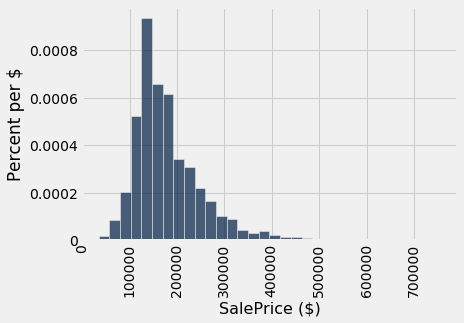

In [29]:
# View a histogram of the sale prices
sales.hist('SalePrice', bins=32, unit='$')

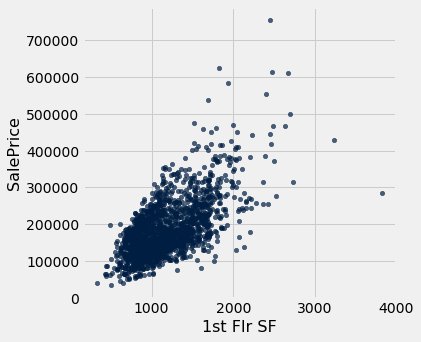

In [30]:
# View a scatter plot looking at the first floor square footage and price
sales.scatter('1st Flr SF', 'SalePrice')

In [31]:
# Defining our function to get the correlation
def standardize(x):
    return (x-np.mean(x))/np.std(x)

def correlation(t, col1, col2):
    x = standardize(t.column(col1))
    y = standardize(t.column(col2))
    return np.mean(x*y)


In [32]:
# Look at the correlation between sales price and first floor square footage
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In [33]:
# Get the correlation between all our variables and price
r = make_array()
for label in sales.labels:
    r = np.append(r, correlation(sales, label, 'SalePrice'))

corr_table = Table().with_columns('Attribute', sales.labels, 'Correlation with Sale Price', r)
corr_table

Attribute,Correlation with Sale Price
SalePrice,1
1st Flr SF,0.642466
2nd Flr SF,0.357522
Total Bsmt SF,0.652979
Garage Area,0.638594
Wood Deck SF,0.352699
Open Porch SF,0.336909
Lot Area,0.290823
Year Built,0.565165
Yr Sold,0.0259486


In [36]:
# Add a column of all ones to the data
# This will enable us to have an intercept in our regression model
sales = sales.with_column('one', np.ones(sales.num_rows))
sales

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold,one
215000,1656,0,1080,528,210,62,31770,1960,2010,1
105000,896,0,882,730,140,0,11622,1961,2010,1
172000,1329,0,1329,312,393,36,14267,1958,2010,1
244000,2110,0,2110,522,0,0,11160,1968,2010,1
189900,928,701,928,482,212,34,13830,1997,2010,1
195500,926,678,926,470,360,36,9978,1998,2010,1
189000,1028,776,994,442,140,60,7500,1999,2010,1
175900,763,892,763,440,157,84,10000,1993,2010,1
185000,1187,0,1168,420,483,21,7980,1992,2010,1
180400,789,676,789,393,0,75,8402,1998,2010,1


In [37]:
# Create training and test splits of our data using the tb.split() method
train, test = sales.split(1001)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [38]:
# Create a function that takes a row and predicts the price based on a vector of coefficents called "slopes"
def predict(slopes, row):
    return sum(slopes * np.array(tuple(row)))

# Use row 0 as an example to make predictions on
example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:\n', example_row)

# Create random slopes (this should lead to poor predictions)
example_slopes = np.random.normal(10, 1, len(example_row))
print('\nUsing slopes\n:', example_slopes)

# The resulting predicted price based on the random slopes
print('\nResult:', predict(example_slopes, example_row))

Predicting sale price for:
 Row(1st Flr SF=1000, 2nd Flr SF=0, Total Bsmt SF=1000.0, Garage Area=575.0, Wood Deck SF=238, Open Porch SF=0, Lot Area=13050, Year Built=1963, Yr Sold=2006, one=1.0)

Using slopes
: [10.15910656 11.93150261  9.71340282  9.24847147  8.84093924 12.21189591
 11.1805025  10.87633168 10.2505921  10.37105267]

Result: 215123.37956582912


In [39]:
# Comparing the actual price and predicted price
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 164000
Predicted sale price using random slopes: 215123.37956582912


In [40]:
# create a function that returns the RMSE for given slopes, features and actual prices
def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5


In [41]:
# Write a function to get the RMSE for the training data using our randomly generated slopes
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes: $%.2f' % rmse_train(example_slopes))


RMSE of all training examples using random slopes: $112634.24


In [42]:
# Get the "best slopes" by miniming the RMSE
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')

# Show the best slopes found and the RMSE found on the training data
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes: $%.2f' % rmse_train(best_slopes))

The best slopes for the training set:


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold,one
78.1199,72.1279,44.5035,50.0248,32.4324,37.0599,0.547047,533.678,-530.307,10.1155


RMSE of all training examples using the best slopes: $28765.34


In [43]:
# Let's now evaluate the RMSE on the test data
test_prices = test.column(0)
test_attributes = test.drop(0)

rmse_linear = rmse(best_slopes, test_attributes, test_prices)
print('Test set RMSE for multiple linear regression: $%.2f'% rmse_linear)

Test set RMSE for multiple linear regression: $33257.15


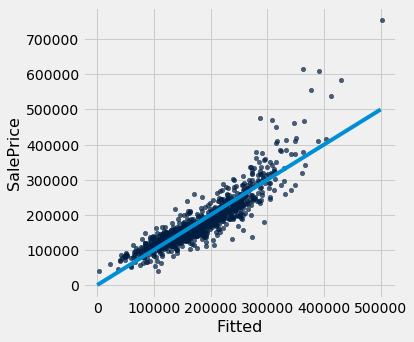

In [44]:
# A function that produces predicted values using the "best slopes" found by minimizing the RMSE
# We will use this function to make 
def fit(row):
    return sum(best_slopes * np.array(tuple(row)))

# Add the predicted values to the test set, and visualize how close the predictions are
test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plots.plot([0, 5e5], [0, 5e5]);

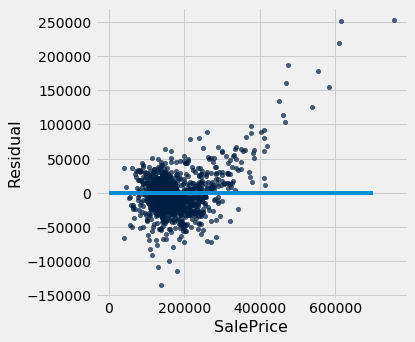

In [45]:
# Create a residual plot to see if there are patterns in the data that are unexplained
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);

In [46]:
# Let's try to use nearest neighbor regression rather than a linear classifier...
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
349265,1164,1377,1149,729,2005
166000,910,475,910,720,1952
110000,720,564,720,240,1947


In [47]:
# Create the functions we need for our nearest neighbor classifier...

def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(tuple(row1)), np.array(tuple(row2)))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))


In [48]:
# Let's get the 5 closest houses to the home in the first row of the test set
example_nn_row = test_nn.drop(0).row(0)
print(test_nn.row(0))
closest(train_nn, example_nn_row, 5, 'SalePrice')

Row(SalePrice=164000, 1st Flr SF=1000, 2nd Flr SF=0, Total Bsmt SF=1000.0, Garage Area=575.0, Year Built=1963)


SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
142500,1003,0,1003,588,1984,25.0599
143250,981,0,981,576,1971,28.0535
129500,988,0,988,624,1962,51.8652
178400,999,0,944,588,1961,57.5326
155000,990,0,990,528,1994,58.0517


In [49]:
# Let's create a prediction function that returns the average house value of the most similar houses
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

149730.0

In [50]:
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 164000
Predicted sale price using nearest neighbors: 149730.0


In [51]:
# Let's calculate the RMSE on the test set for the kNN classifier
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

# Which is better, linear regression of kNN? 
print('Test set RMSE for multiple linear regression: $%.2f' % rmse_linear)
print('Test set RMSE for nearest neighbor regression: $%.2f' % rmse_nn)

Test set RMSE for multiple linear regression: $33257.15
Test set RMSE for nearest neighbor regression: $34573.34


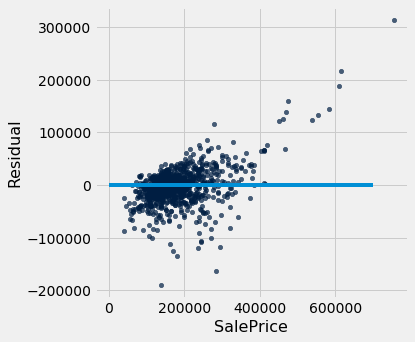

In [52]:
# Let's look at the pattern of residuals again
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plots.plot([0, 7e5], [0, 0]);